In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder2 import Autoencoder2, reduce_dimensions2
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster2

# Data Preprocessing

In [2]:
n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# Autoencoder

In [6]:
autoencoder2 = Autoencoder2()
auto2_criterion = nn.BCELoss()  
auto2_optimizer = optim.Adam(autoencoder2.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
num_epochs = 5
for epoch in range(num_epochs):
    autoencoder2.train()
    train_loss = 0

    for images, _ in train_loader_auto:
        images = images.to(device)

        auto2_optimizer.zero_grad()
        outputs = autoencoder2(images)
        loss = auto2_criterion(outputs, images) 
        
        loss.backward()
        auto2_optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_auto)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/5], Loss: 0.1233
Epoch [2/5], Loss: 0.0882
Epoch [3/5], Loss: 0.0833
Epoch [4/5], Loss: 0.0806
Epoch [5/5], Loss: 0.0787


In [8]:
autoencoder2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions2(train_loader_auto, autoencoder2.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder2.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Experiment

In [9]:
# cluster: 6, CLient: 10

In [9]:
alpha_values = [0.1, 0.5, 1, 5, 10, 20]
num_clients = 10
num_clusters = 6
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [10]:
# classic
trainingset = train_loader.dataset
trial_model = classification_model()
global_model_classic = classification_model()
rounds_classic = 4

In [15]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")

    # Classic
    partitioned_data_classic = partition.balanced_dirichlet_partition(
        trainingset, partitions_number=num_clients, alpha=alpha
    )

    classic_client_loaders = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]


    local_models_classic = [copy.deepcopy(global_model_classic) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []

    for epoch in range(1, n_epochs + 1):
        train(epoch, trial_model, train_loader, optimizer, log_interval, train_losses, train_counter)

    test_losses_classic_weak = []
    test(trial_model, test_loader, test_losses_classic_weak)

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if alpha not in results["classic"]:
            results["classic"][alpha] = {"losses": [], "accuracy": []}

        results["classic"][alpha]["losses"].extend(test_losses)
        results["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    # Erstelle Clients
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_classic.items()]
    
    # Jeder Client berechnet seine Labelverteilung
    client_distributions = [client.compute_label_distribution() for client in clients]
    
    # Server führt Clustering durch
    server = cluster2.FederatedClusterServer(num_clusters)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_classic)
    
    partitioned_data_classic_clustered = clustered_data
    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)

    targets = trainingset.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)

    partitioned_data_classic_clustered = clustered_data"
    """

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic[0: num_clusters]):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if alpha not in clusteredResults["classic"]:
            clusteredResults["classic"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["classic"][alpha]["losses"].extend(test_losses)
        clusteredResults["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.258025


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.259676
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.238542
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.194952
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.206163
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.160000
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.171416
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.150080
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.093712
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.026855
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.019943
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.955795
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.815939
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.877526
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.665248
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.735038
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.561881
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.496183
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.365769
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.403112
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.538226
Train Epoch: 1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1386, Accuracy: 9570/10000 (96%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 2.306325
Train Epoch: 1 [1000/11393 (9%)]	Loss: 2.268623
Train Epoch: 1 [2000/11393 (18%)]	Loss: 2.259237
Train Epoch: 1 [3000/11393 (26%)]	Loss: 2.233358
Train Epoch: 1 [4000/11393 (35%)]	Loss: 2.127175
Train Epoch: 1 [5000/11393 (44%)]	Loss: 2.070156
Train Epoch: 1 [6000/11393 (53%)]	Loss: 1.996178
Train Epoch: 1 [7000/11393 (61%)]	Loss: 1.914505
Train Epoch: 1 [8000/11393 (70%)]	Loss: 1.869950
Train Epoch: 1 [9000/11393 (79%)]	Loss: 1.802147
Train Epoch: 1 [10000/11393 (88%)]	Loss: 1.843971
Train Epoch: 1 [11000/11393 (96%)]	Loss: 1.811933
Train Epoch: 2 [0/11393 (0%)]	Loss: 1.649724
Train Epoch: 2 [1000/11393 (9%)]	Loss: 1.639211
Train Epoch: 2 [2000/11393 (18%)]	Loss: 1.547576
Train Epoch: 2 [3000/11393 (26%)]	Loss: 1.398562
Train Epoch: 2 [4000/11393 (35%)]	Loss: 1.316741
Train Epoch: 2 [5000/11393 (44%)]	Loss: 1.267535
Train Epoch: 2 [6000/11393 (53%)]	Loss: 

# PCA

In [16]:
# PCA
#trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca = classification_model()
global_model_pca = classification_model() 

In [21]:
trainingset_pca = train_loader_pca.dataset

for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")

    partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

    pca_client_loaders = []
    local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

    for client_idx, client_indices in partitioned_data_pca.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  
        
        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  
        
        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081  
        
        client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))

    optimizer = optim.SGD(trial_model_pca.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):
        train(epoch, trial_model_pca, pca_client_loaders[0], optimizer, log_interval, train_losses, train_counter)
 
    test_losses_classic_pca = []
    test(trial_model_pca, pca_client_loaders[0], test_losses_classic_pca)

    rounds_pca = 4
    
    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)

        if alpha not in results["pca"]:
            results["pca"][alpha] = {"losses": [], "accuracy": []}

        results["pca"][alpha]["losses"].extend(test_losses)
        results["pca"][alpha]["accuracy"].extend(test_accuracies_pca)

    ###################### CLUSTERING PART ######################
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_pca.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_clusters)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_pca)
    
    partitioned_data_pca_clustered = clustered_data
    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)
    targets = trainingset_pca.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)

    partitioned_data_pca_clustered = clustered_data"
    """
    pca_client_loaders_clustered = []
    
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]
        client_labels = [trainingset_pca[i][1] for i in client_indices]
        
        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1) 
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())
        
        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081
        
        client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))

    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, pca_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)

        if alpha not in clusteredResults["pca"]:
            clusteredResults["pca"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["pca"][alpha]["losses"].extend(test_losses)
        clusteredResults["pca"][alpha]["accuracy"].extend(test_accuracies_pca)


Running experiment with alpha: 0.1 


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/11393 (0%)]	Loss: 0.338023
Train Epoch: 1 [1000/11393 (9%)]	Loss: 0.369023
Train Epoch: 1 [2000/11393 (18%)]	Loss: 0.368625
Train Epoch: 1 [3000/11393 (26%)]	Loss: 0.308990
Train Epoch: 1 [4000/11393 (35%)]	Loss: 0.217746
Train Epoch: 1 [5000/11393 (44%)]	Loss: 0.232063
Train Epoch: 1 [6000/11393 (53%)]	Loss: 0.248489
Train Epoch: 1 [7000/11393 (61%)]	Loss: 0.261487
Train Epoch: 1 [8000/11393 (70%)]	Loss: 0.374596
Train Epoch: 1 [9000/11393 (79%)]	Loss: 0.412826
Train Epoch: 1 [10000/11393 (88%)]	Loss: 0.251825
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.516510
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.266870
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.253266
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.210130
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.392992
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.213320
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.295948
Train Epoch: 2 [6000/11393 (53%)]	Loss: 0.264447
Train Epoch: 2 [7000/11393 (61%)]	Loss: 0.388186
Train Epoch: 2 [8000/11393 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1125, Accuracy: 11049/11393 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.632754
Train Epoch: 1 [1000/11393 (9%)]	Loss: 0.314498
Train Epoch: 1 [2000/11393 (18%)]	Loss: 0.486985
Train Epoch: 1 [3000/11393 (26%)]	Loss: 0.233136
Train Epoch: 1 [4000/11393 (35%)]	Loss: 0.364851
Train Epoch: 1 [5000/11393 (44%)]	Loss: 0.408905
Train Epoch: 1 [6000/11393 (53%)]	Loss: 0.203743
Train Epoch: 1 [7000/11393 (61%)]	Loss: 0.364182
Train Epoch: 1 [8000/11393 (70%)]	Loss: 0.341307
Train Epoch: 1 [9000/11393 (79%)]	Loss: 0.289926
Train Epoch: 1 [10000/11393 (88%)]	Loss: 0.266233
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.217507
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.284335
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.214281
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.262275
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.232054
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.130193
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.197689
Train Epoch: 2 [6000/11393 (53%)]	Loss:

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2000/11393 (18%)]	Loss: 0.243894
Train Epoch: 1 [3000/11393 (26%)]	Loss: 0.243084
Train Epoch: 1 [4000/11393 (35%)]	Loss: 0.307794
Train Epoch: 1 [5000/11393 (44%)]	Loss: 0.212009
Train Epoch: 1 [6000/11393 (53%)]	Loss: 0.363991
Train Epoch: 1 [7000/11393 (61%)]	Loss: 0.137645
Train Epoch: 1 [8000/11393 (70%)]	Loss: 0.191374
Train Epoch: 1 [9000/11393 (79%)]	Loss: 0.266679
Train Epoch: 1 [10000/11393 (88%)]	Loss: 0.154802
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.273053
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.132769
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.355853
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.139198
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.203575
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.242945
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.180485
Train Epoch: 2 [6000/11393 (53%)]	Loss: 0.212300
Train Epoch: 2 [7000/11393 (61%)]	Loss: 0.215284
Train Epoch: 2 [8000/11393 (70%)]	Loss: 0.142973
Train Epoch: 2 [9000/11393 (79%)]	Loss: 0.189492
Train Epoch: 2 [10000/1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6203, Accuracy: 9475/10000 (95%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.416984
Train Epoch: 1 [1000/11393 (9%)]	Loss: 0.300886
Train Epoch: 1 [2000/11393 (18%)]	Loss: 0.184191
Train Epoch: 1 [3000/11393 (26%)]	Loss: 0.221111
Train Epoch: 1 [4000/11393 (35%)]	Loss: 0.199871
Train Epoch: 1 [5000/11393 (44%)]	Loss: 0.162331
Train Epoch: 1 [6000/11393 (53%)]	Loss: 0.186656
Train Epoch: 1 [7000/11393 (61%)]	Loss: 0.122746
Train Epoch: 1 [8000/11393 (70%)]	Loss: 0.080309
Train Epoch: 1 [9000/11393 (79%)]	Loss: 0.203398
Train Epoch: 1 [10000/11393 (88%)]	Loss: 0.159221
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.163450
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.236751
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.272935
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.234899
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.177979
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.135729
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.225219
Train Epoch: 2 [6000/11393 (53%)]	Loss: 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/8115 (0%)]	Loss: 2.028916
Train Epoch: 1 [1000/8115 (12%)]	Loss: 0.924101
Train Epoch: 1 [2000/8115 (24%)]	Loss: 0.789377
Train Epoch: 1 [3000/8115 (37%)]	Loss: 0.760547
Train Epoch: 1 [4000/8115 (49%)]	Loss: 0.774323
Train Epoch: 1 [5000/8115 (61%)]	Loss: 0.674201
Train Epoch: 1 [6000/8115 (73%)]	Loss: 0.608416
Train Epoch: 1 [7000/8115 (85%)]	Loss: 0.529972
Train Epoch: 1 [8000/8115 (98%)]	Loss: 0.694749
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.617747
Train Epoch: 2 [1000/8115 (12%)]	Loss: 0.710024
Train Epoch: 2 [2000/8115 (24%)]	Loss: 0.549491
Train Epoch: 2 [3000/8115 (37%)]	Loss: 0.692223
Train Epoch: 2 [4000/8115 (49%)]	Loss: 0.466740
Train Epoch: 2 [5000/8115 (61%)]	Loss: 0.408810
Train Epoch: 2 [6000/8115 (73%)]	Loss: 0.485439
Train Epoch: 2 [7000/8115 (85%)]	Loss: 0.293664
Train Epoch: 2 [8000/8115 (98%)]	Loss: 0.584205
Train Epoch: 3 [0/8115 (0%)]	Loss: 0.403073
Train Epoch: 3 [1000/8115 (12%)]	Loss: 0.593578
Train Epoch: 3 [2000/8115 (24%)]	Loss: 0.361588
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1664, Accuracy: 7718/8115 (95%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.201170
Train Epoch: 1 [1000/8115 (12%)]	Loss: 0.274545
Train Epoch: 1 [2000/8115 (24%)]	Loss: 0.185178
Train Epoch: 1 [3000/8115 (37%)]	Loss: 0.344121
Train Epoch: 1 [4000/8115 (49%)]	Loss: 0.272935
Train Epoch: 1 [5000/8115 (61%)]	Loss: 0.090796
Train Epoch: 1 [6000/8115 (73%)]	Loss: 0.196117
Train Epoch: 1 [7000/8115 (85%)]	Loss: 0.123289
Train Epoch: 1 [8000/8115 (98%)]	Loss: 0.165683
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.301419
Train Epoch: 2 [1000/8115 (12%)]	Loss: 0.144299
Train Epoch: 2 [2000/8115 (24%)]	Loss: 0.099435
Train Epoch: 2 [3000/8115 (37%)]	Loss: 0.202768
Train Epoch: 2 [4000/8115 (49%)]	Loss: 0.231584
Train Epoch: 2 [5000/8115 (61%)]	Loss: 0.303985
Train Epoch: 2 [6000/8115 (73%)]	Loss: 0.155569
Train Epoch: 2 [7000/8115 (85%)]	Loss: 0.312825
Train Epoch: 2 [8000/8115 (98%)]	Loss: 0.185467
Train Epoch: 3 [0/8115 (0%)]	Loss: 0.390965
Train Epoch: 3 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1000/11957 (8%)]	Loss: 0.095556
Train Epoch: 1 [2000/11957 (17%)]	Loss: 0.463706
Train Epoch: 1 [3000/11957 (25%)]	Loss: 0.128851
Train Epoch: 1 [4000/11957 (33%)]	Loss: 0.233176
Train Epoch: 1 [5000/11957 (42%)]	Loss: 0.168016
Train Epoch: 1 [6000/11957 (50%)]	Loss: 0.308017
Train Epoch: 1 [7000/11957 (58%)]	Loss: 0.105794
Train Epoch: 1 [8000/11957 (67%)]	Loss: 0.159048
Train Epoch: 1 [9000/11957 (75%)]	Loss: 0.177584
Train Epoch: 1 [10000/11957 (83%)]	Loss: 0.191853
Train Epoch: 1 [11000/11957 (92%)]	Loss: 0.232418
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.281611
Train Epoch: 2 [1000/11957 (8%)]	Loss: 0.226108
Train Epoch: 2 [2000/11957 (17%)]	Loss: 0.153746
Train Epoch: 2 [3000/11957 (25%)]	Loss: 0.219083
Train Epoch: 2 [4000/11957 (33%)]	Loss: 0.139184
Train Epoch: 2 [5000/11957 (42%)]	Loss: 0.139107
Train Epoch: 2 [6000/11957 (50%)]	Loss: 0.143383
Train Epoch: 2 [7000/11957 (58%)]	Loss: 0.193449
Train Epoch: 2 [8000/11957 (67%)]	Loss: 0.184374
Train Epoch: 2 [9000/119

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4002, Accuracy: 9716/10000 (97%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.204584
Train Epoch: 1 [1000/11957 (8%)]	Loss: 0.145593
Train Epoch: 1 [2000/11957 (17%)]	Loss: 0.091096
Train Epoch: 1 [3000/11957 (25%)]	Loss: 0.236026
Train Epoch: 1 [4000/11957 (33%)]	Loss: 0.250237
Train Epoch: 1 [5000/11957 (42%)]	Loss: 0.399000
Train Epoch: 1 [6000/11957 (50%)]	Loss: 0.141768
Train Epoch: 1 [7000/11957 (58%)]	Loss: 0.243235
Train Epoch: 1 [8000/11957 (67%)]	Loss: 0.178814
Train Epoch: 1 [9000/11957 (75%)]	Loss: 0.228561
Train Epoch: 1 [10000/11957 (83%)]	Loss: 0.217862
Train Epoch: 1 [11000/11957 (92%)]	Loss: 0.166534
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.250692
Train Epoch: 2 [1000/11957 (8%)]	Loss: 0.277980
Train Epoch: 2 [2000/11957 (17%)]	Loss: 0.130139
Train Epoch: 2 [3000/11957 (25%)]	Loss: 0.102520
Train Epoch: 2 [4000/11957 (33%)]	Loss: 0.168122
Train Epoch: 2 [5000/11957 (42%)]	Loss: 0.302162
Train Epoch: 2 [6000/11957 (50%)]	Loss: 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/4617 (0%)]	Loss: 0.766555
Train Epoch: 1 [1000/4617 (21%)]	Loss: 0.515454
Train Epoch: 1 [2000/4617 (43%)]	Loss: 0.462682
Train Epoch: 1 [3000/4617 (64%)]	Loss: 0.374712
Train Epoch: 1 [4000/4617 (85%)]	Loss: 0.331615
Train Epoch: 2 [0/4617 (0%)]	Loss: 0.446546
Train Epoch: 2 [1000/4617 (21%)]	Loss: 0.438013
Train Epoch: 2 [2000/4617 (43%)]	Loss: 0.255431
Train Epoch: 2 [3000/4617 (64%)]	Loss: 0.338707
Train Epoch: 2 [4000/4617 (85%)]	Loss: 0.441521
Train Epoch: 3 [0/4617 (0%)]	Loss: 0.338903
Train Epoch: 3 [1000/4617 (21%)]	Loss: 0.329843
Train Epoch: 3 [2000/4617 (43%)]	Loss: 0.382477
Train Epoch: 3 [3000/4617 (64%)]	Loss: 0.400033
Train Epoch: 3 [4000/4617 (85%)]	Loss: 0.302702
Train Epoch: 4 [0/4617 (0%)]	Loss: 0.254594
Train Epoch: 4 [1000/4617 (21%)]	Loss: 0.478184
Train Epoch: 4 [2000/4617 (43%)]	Loss: 0.391990
Train Epoch: 4 [3000/4617 (64%)]	Loss: 0.447064
Train Epoch: 4 [4000/4617 (85%)]	Loss: 0.306511
Train Epoch: 5 [0/4617 (0%)]	Loss: 0.309518
Train Epoch:

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1319, Accuracy: 4419/4617 (96%)

Round 1/4
Training client 1
Train Epoch: 1 [0/4617 (0%)]	Loss: 0.171299
Train Epoch: 1 [1000/4617 (21%)]	Loss: 0.124516
Train Epoch: 1 [2000/4617 (43%)]	Loss: 0.175808
Train Epoch: 1 [3000/4617 (64%)]	Loss: 0.109317
Train Epoch: 1 [4000/4617 (85%)]	Loss: 0.145575
Train Epoch: 2 [0/4617 (0%)]	Loss: 0.135248
Train Epoch: 2 [1000/4617 (21%)]	Loss: 0.082254
Train Epoch: 2 [2000/4617 (43%)]	Loss: 0.119733
Train Epoch: 2 [3000/4617 (64%)]	Loss: 0.164394
Train Epoch: 2 [4000/4617 (85%)]	Loss: 0.239963
Train Epoch: 3 [0/4617 (0%)]	Loss: 0.223785
Train Epoch: 3 [1000/4617 (21%)]	Loss: 0.114285
Train Epoch: 3 [2000/4617 (43%)]	Loss: 0.155001
Train Epoch: 3 [3000/4617 (64%)]	Loss: 0.099982
Train Epoch: 3 [4000/4617 (85%)]	Loss: 0.176303
Train Epoch: 4 [0/4617 (0%)]	Loss: 0.114932
Train Epoch: 4 [1000/4617 (21%)]	Loss: 0.210794
Train Epoch: 4 [2000/4617 (43%)]	Loss: 0.034792
Train Epoch: 4 [3000/4617 (64%)]	Loss: 0.137641
Train Epoch: 4 [400

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1000/7591 (13%)]	Loss: 0.095384
Train Epoch: 1 [2000/7591 (26%)]	Loss: 0.098756
Train Epoch: 1 [3000/7591 (39%)]	Loss: 0.138494
Train Epoch: 1 [4000/7591 (53%)]	Loss: 0.173013
Train Epoch: 1 [5000/7591 (66%)]	Loss: 0.102217
Train Epoch: 1 [6000/7591 (79%)]	Loss: 0.235160
Train Epoch: 1 [7000/7591 (92%)]	Loss: 0.172896
Train Epoch: 2 [0/7591 (0%)]	Loss: 0.128521
Train Epoch: 2 [1000/7591 (13%)]	Loss: 0.152754
Train Epoch: 2 [2000/7591 (26%)]	Loss: 0.123931
Train Epoch: 2 [3000/7591 (39%)]	Loss: 0.094044
Train Epoch: 2 [4000/7591 (53%)]	Loss: 0.165764
Train Epoch: 2 [5000/7591 (66%)]	Loss: 0.086897
Train Epoch: 2 [6000/7591 (79%)]	Loss: 0.154991
Train Epoch: 2 [7000/7591 (92%)]	Loss: 0.253000
Train Epoch: 3 [0/7591 (0%)]	Loss: 0.284574
Train Epoch: 3 [1000/7591 (13%)]	Loss: 0.098829
Train Epoch: 3 [2000/7591 (26%)]	Loss: 0.183956
Train Epoch: 3 [3000/7591 (39%)]	Loss: 0.068123
Train Epoch: 3 [4000/7591 (53%)]	Loss: 0.137220
Train Epoch: 3 [5000/7591 (66%)]	Loss: 0.257674


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3348, Accuracy: 9793/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/7591 (0%)]	Loss: 0.298703
Train Epoch: 1 [1000/7591 (13%)]	Loss: 0.122013
Train Epoch: 1 [2000/7591 (26%)]	Loss: 0.108880
Train Epoch: 1 [3000/7591 (39%)]	Loss: 0.197377
Train Epoch: 1 [4000/7591 (53%)]	Loss: 0.242702
Train Epoch: 1 [5000/7591 (66%)]	Loss: 0.139344
Train Epoch: 1 [6000/7591 (79%)]	Loss: 0.146405
Train Epoch: 1 [7000/7591 (92%)]	Loss: 0.137354
Train Epoch: 2 [0/7591 (0%)]	Loss: 0.086812
Train Epoch: 2 [1000/7591 (13%)]	Loss: 0.138448
Train Epoch: 2 [2000/7591 (26%)]	Loss: 0.097363
Train Epoch: 2 [3000/7591 (39%)]	Loss: 0.129444
Train Epoch: 2 [4000/7591 (53%)]	Loss: 0.166115
Train Epoch: 2 [5000/7591 (66%)]	Loss: 0.326872
Train Epoch: 2 [6000/7591 (79%)]	Loss: 0.133757
Train Epoch: 2 [7000/7591 (92%)]	Loss: 0.145209
Train Epoch: 3 [0/7591 (0%)]	Loss: 0.084483
Train Epoch: 3 [1000/7591 (13%)]	Loss: 0.166389
Train Epoch: 3 [2000/7591 (26%)]	Loss: 0.106952
Train Epoch: 3

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/6701 (0%)]	Loss: 0.611608
Train Epoch: 1 [1000/6701 (15%)]	Loss: 0.440006
Train Epoch: 1 [2000/6701 (29%)]	Loss: 0.357568
Train Epoch: 1 [3000/6701 (44%)]	Loss: 0.393669
Train Epoch: 1 [4000/6701 (59%)]	Loss: 0.345185
Train Epoch: 1 [5000/6701 (74%)]	Loss: 0.385193
Train Epoch: 1 [6000/6701 (88%)]	Loss: 0.324403
Train Epoch: 2 [0/6701 (0%)]	Loss: 0.452032
Train Epoch: 2 [1000/6701 (15%)]	Loss: 0.368166
Train Epoch: 2 [2000/6701 (29%)]	Loss: 0.505194
Train Epoch: 2 [3000/6701 (44%)]	Loss: 0.454557
Train Epoch: 2 [4000/6701 (59%)]	Loss: 0.687143
Train Epoch: 2 [5000/6701 (74%)]	Loss: 0.299700
Train Epoch: 2 [6000/6701 (88%)]	Loss: 0.512536
Train Epoch: 3 [0/6701 (0%)]	Loss: 0.449455
Train Epoch: 3 [1000/6701 (15%)]	Loss: 0.385214
Train Epoch: 3 [2000/6701 (29%)]	Loss: 0.402890
Train Epoch: 3 [3000/6701 (44%)]	Loss: 0.311811
Train Epoch: 3 [4000/6701 (59%)]	Loss: 0.495948
Train Epoch: 3 [5000/6701 (74%)]	Loss: 0.357074
Train Epoch: 3 [6000/6701 (88%)]	Loss: 0.298391
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1423, Accuracy: 6427/6701 (96%)

Round 1/4
Training client 1
Train Epoch: 1 [0/6701 (0%)]	Loss: 0.191286
Train Epoch: 1 [1000/6701 (15%)]	Loss: 0.151473
Train Epoch: 1 [2000/6701 (29%)]	Loss: 0.119647
Train Epoch: 1 [3000/6701 (44%)]	Loss: 0.052532
Train Epoch: 1 [4000/6701 (59%)]	Loss: 0.102541
Train Epoch: 1 [5000/6701 (74%)]	Loss: 0.071494
Train Epoch: 1 [6000/6701 (88%)]	Loss: 0.229097
Train Epoch: 2 [0/6701 (0%)]	Loss: 0.141366
Train Epoch: 2 [1000/6701 (15%)]	Loss: 0.133958
Train Epoch: 2 [2000/6701 (29%)]	Loss: 0.069335
Train Epoch: 2 [3000/6701 (44%)]	Loss: 0.238476
Train Epoch: 2 [4000/6701 (59%)]	Loss: 0.223756
Train Epoch: 2 [5000/6701 (74%)]	Loss: 0.069991
Train Epoch: 2 [6000/6701 (88%)]	Loss: 0.182822
Train Epoch: 3 [0/6701 (0%)]	Loss: 0.400466
Train Epoch: 3 [1000/6701 (15%)]	Loss: 0.362918
Train Epoch: 3 [2000/6701 (29%)]	Loss: 0.564540
Train Epoch: 3 [3000/6701 (44%)]	Loss: 0.239723
Train Epoch: 3 [4000/6701 (59%)]	Loss: 0.144005
Train Epoch: 3 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1000/12086 (8%)]	Loss: 0.148324
Train Epoch: 1 [2000/12086 (17%)]	Loss: 0.143008
Train Epoch: 1 [3000/12086 (25%)]	Loss: 0.265719
Train Epoch: 1 [4000/12086 (33%)]	Loss: 0.156451
Train Epoch: 1 [5000/12086 (41%)]	Loss: 0.106717
Train Epoch: 1 [6000/12086 (50%)]	Loss: 0.044481
Train Epoch: 1 [7000/12086 (58%)]	Loss: 0.091208
Train Epoch: 1 [8000/12086 (66%)]	Loss: 0.196883
Train Epoch: 1 [9000/12086 (74%)]	Loss: 0.247799
Train Epoch: 1 [10000/12086 (83%)]	Loss: 0.115980
Train Epoch: 1 [11000/12086 (91%)]	Loss: 0.181600
Train Epoch: 1 [10320/12086 (99%)]	Loss: 0.186665
Train Epoch: 2 [0/12086 (0%)]	Loss: 0.115814
Train Epoch: 2 [1000/12086 (8%)]	Loss: 0.296028
Train Epoch: 2 [2000/12086 (17%)]	Loss: 0.089989
Train Epoch: 2 [3000/12086 (25%)]	Loss: 0.094473
Train Epoch: 2 [4000/12086 (33%)]	Loss: 0.157344
Train Epoch: 2 [5000/12086 (41%)]	Loss: 0.154941
Train Epoch: 2 [6000/12086 (50%)]	Loss: 0.225287
Train Epoch: 2 [7000/12086 (58%)]	Loss: 0.350759
Train Epoch: 2 [8000/12

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2883, Accuracy: 9817/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/12086 (0%)]	Loss: 0.107163
Train Epoch: 1 [1000/12086 (8%)]	Loss: 0.239499
Train Epoch: 1 [2000/12086 (17%)]	Loss: 0.224032
Train Epoch: 1 [3000/12086 (25%)]	Loss: 0.142644
Train Epoch: 1 [4000/12086 (33%)]	Loss: 0.140777
Train Epoch: 1 [5000/12086 (41%)]	Loss: 0.098347
Train Epoch: 1 [6000/12086 (50%)]	Loss: 0.084356
Train Epoch: 1 [7000/12086 (58%)]	Loss: 0.266298
Train Epoch: 1 [8000/12086 (66%)]	Loss: 0.165446
Train Epoch: 1 [9000/12086 (74%)]	Loss: 0.184740
Train Epoch: 1 [10000/12086 (83%)]	Loss: 0.103101
Train Epoch: 1 [11000/12086 (91%)]	Loss: 0.084868
Train Epoch: 1 [10320/12086 (99%)]	Loss: 0.137648
Train Epoch: 2 [0/12086 (0%)]	Loss: 0.093221
Train Epoch: 2 [1000/12086 (8%)]	Loss: 0.122500
Train Epoch: 2 [2000/12086 (17%)]	Loss: 0.224174
Train Epoch: 2 [3000/12086 (25%)]	Loss: 0.142335
Train Epoch: 2 [4000/12086 (33%)]	Loss: 0.160859
Train Epoch: 2 [5000/12086 (41%)]	Loss:

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/6535 (0%)]	Loss: 0.426739
Train Epoch: 1 [1000/6535 (15%)]	Loss: 0.460854
Train Epoch: 1 [2000/6535 (30%)]	Loss: 0.210665
Train Epoch: 1 [3000/6535 (45%)]	Loss: 0.407581
Train Epoch: 1 [4000/6535 (61%)]	Loss: 0.494703
Train Epoch: 1 [5000/6535 (76%)]	Loss: 0.326884
Train Epoch: 1 [6000/6535 (91%)]	Loss: 0.371310
Train Epoch: 2 [0/6535 (0%)]	Loss: 0.327456
Train Epoch: 2 [1000/6535 (15%)]	Loss: 0.285820
Train Epoch: 2 [2000/6535 (30%)]	Loss: 0.423084
Train Epoch: 2 [3000/6535 (45%)]	Loss: 0.454208
Train Epoch: 2 [4000/6535 (61%)]	Loss: 0.288432
Train Epoch: 2 [5000/6535 (76%)]	Loss: 0.291227
Train Epoch: 2 [6000/6535 (91%)]	Loss: 0.561449
Train Epoch: 3 [0/6535 (0%)]	Loss: 0.211653
Train Epoch: 3 [1000/6535 (15%)]	Loss: 0.352580
Train Epoch: 3 [2000/6535 (30%)]	Loss: 0.359789
Train Epoch: 3 [3000/6535 (45%)]	Loss: 0.167397
Train Epoch: 3 [4000/6535 (61%)]	Loss: 0.375049
Train Epoch: 3 [5000/6535 (76%)]	Loss: 0.382801
Train Epoch: 3 [6000/6535 (91%)]	Loss: 0.257086
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1260, Accuracy: 6294/6535 (96%)

Round 1/4
Training client 1
Train Epoch: 1 [0/6535 (0%)]	Loss: 0.112910
Train Epoch: 1 [1000/6535 (15%)]	Loss: 0.075981
Train Epoch: 1 [2000/6535 (30%)]	Loss: 0.322464
Train Epoch: 1 [3000/6535 (45%)]	Loss: 0.093903
Train Epoch: 1 [4000/6535 (61%)]	Loss: 0.135103
Train Epoch: 1 [5000/6535 (76%)]	Loss: 0.168862
Train Epoch: 1 [6000/6535 (91%)]	Loss: 0.219373
Train Epoch: 2 [0/6535 (0%)]	Loss: 0.074282
Train Epoch: 2 [1000/6535 (15%)]	Loss: 0.093048
Train Epoch: 2 [2000/6535 (30%)]	Loss: 0.090234
Train Epoch: 2 [3000/6535 (45%)]	Loss: 0.060810
Train Epoch: 2 [4000/6535 (61%)]	Loss: 0.138219
Train Epoch: 2 [5000/6535 (76%)]	Loss: 0.218129
Train Epoch: 2 [6000/6535 (91%)]	Loss: 0.317951
Train Epoch: 3 [0/6535 (0%)]	Loss: 0.102953
Train Epoch: 3 [1000/6535 (15%)]	Loss: 0.114995
Train Epoch: 3 [2000/6535 (30%)]	Loss: 0.154835
Train Epoch: 3 [3000/6535 (45%)]	Loss: 0.280892
Train Epoch: 3 [4000/6535 (61%)]	Loss: 0.170082
Train Epoch: 3 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2000/12056 (17%)]	Loss: 0.049009
Train Epoch: 1 [3000/12056 (25%)]	Loss: 0.099855
Train Epoch: 1 [4000/12056 (33%)]	Loss: 0.222299
Train Epoch: 1 [5000/12056 (41%)]	Loss: 0.132161
Train Epoch: 1 [6000/12056 (50%)]	Loss: 0.109586
Train Epoch: 1 [7000/12056 (58%)]	Loss: 0.197035
Train Epoch: 1 [8000/12056 (66%)]	Loss: 0.103487
Train Epoch: 1 [9000/12056 (74%)]	Loss: 0.088712
Train Epoch: 1 [10000/12056 (83%)]	Loss: 0.133247
Train Epoch: 1 [11000/12056 (91%)]	Loss: 0.035205
Train Epoch: 1 [6720/12056 (99%)]	Loss: 0.339500
Train Epoch: 2 [0/12056 (0%)]	Loss: 0.130080
Train Epoch: 2 [1000/12056 (8%)]	Loss: 0.249224
Train Epoch: 2 [2000/12056 (17%)]	Loss: 0.400293
Train Epoch: 2 [3000/12056 (25%)]	Loss: 0.165177
Train Epoch: 2 [4000/12056 (33%)]	Loss: 0.145720
Train Epoch: 2 [5000/12056 (41%)]	Loss: 0.199352
Train Epoch: 2 [6000/12056 (50%)]	Loss: 0.083927
Train Epoch: 2 [7000/12056 (58%)]	Loss: 0.324937
Train Epoch: 2 [8000/12056 (66%)]	Loss: 0.079463
Train Epoch: 2 [9000/12

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2519, Accuracy: 9832/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/12056 (0%)]	Loss: 0.085523
Train Epoch: 1 [1000/12056 (8%)]	Loss: 0.064575
Train Epoch: 1 [2000/12056 (17%)]	Loss: 0.134974
Train Epoch: 1 [3000/12056 (25%)]	Loss: 0.175970
Train Epoch: 1 [4000/12056 (33%)]	Loss: 0.135690
Train Epoch: 1 [5000/12056 (41%)]	Loss: 0.126895
Train Epoch: 1 [6000/12056 (50%)]	Loss: 0.186483
Train Epoch: 1 [7000/12056 (58%)]	Loss: 0.117471
Train Epoch: 1 [8000/12056 (66%)]	Loss: 0.096042
Train Epoch: 1 [9000/12056 (74%)]	Loss: 0.096604
Train Epoch: 1 [10000/12056 (83%)]	Loss: 0.087023
Train Epoch: 1 [11000/12056 (91%)]	Loss: 0.103526
Train Epoch: 1 [6720/12056 (99%)]	Loss: 0.100785
Train Epoch: 2 [0/12056 (0%)]	Loss: 0.094981
Train Epoch: 2 [1000/12056 (8%)]	Loss: 0.163408
Train Epoch: 2 [2000/12056 (17%)]	Loss: 0.155995
Train Epoch: 2 [3000/12056 (25%)]	Loss: 0.161211
Train Epoch: 2 [4000/12056 (33%)]	Loss: 0.137372
Train Epoch: 2 [5000/12056 (41%)]	Loss: 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/6398 (0%)]	Loss: 0.268481
Train Epoch: 1 [1000/6398 (16%)]	Loss: 0.362792
Train Epoch: 1 [2000/6398 (31%)]	Loss: 0.269548
Train Epoch: 1 [3000/6398 (47%)]	Loss: 0.226405
Train Epoch: 1 [4000/6398 (62%)]	Loss: 0.261408
Train Epoch: 1 [5000/6398 (78%)]	Loss: 0.276007
Train Epoch: 1 [6000/6398 (94%)]	Loss: 0.343488
Train Epoch: 2 [0/6398 (0%)]	Loss: 0.243061
Train Epoch: 2 [1000/6398 (16%)]	Loss: 0.393962
Train Epoch: 2 [2000/6398 (31%)]	Loss: 0.330109
Train Epoch: 2 [3000/6398 (47%)]	Loss: 0.359258
Train Epoch: 2 [4000/6398 (62%)]	Loss: 0.316891
Train Epoch: 2 [5000/6398 (78%)]	Loss: 0.196492
Train Epoch: 2 [6000/6398 (94%)]	Loss: 0.284190
Train Epoch: 3 [0/6398 (0%)]	Loss: 0.301032
Train Epoch: 3 [1000/6398 (16%)]	Loss: 0.299590
Train Epoch: 3 [2000/6398 (31%)]	Loss: 0.268836
Train Epoch: 3 [3000/6398 (47%)]	Loss: 0.256344
Train Epoch: 3 [4000/6398 (62%)]	Loss: 0.280785
Train Epoch: 3 [5000/6398 (78%)]	Loss: 0.321319
Train Epoch: 3 [6000/6398 (94%)]	Loss: 0.435210
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0997, Accuracy: 6203/6398 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/6398 (0%)]	Loss: 0.082844
Train Epoch: 1 [1000/6398 (16%)]	Loss: 0.188494
Train Epoch: 1 [2000/6398 (31%)]	Loss: 0.160925
Train Epoch: 1 [3000/6398 (47%)]	Loss: 0.155317
Train Epoch: 1 [4000/6398 (62%)]	Loss: 0.134774
Train Epoch: 1 [5000/6398 (78%)]	Loss: 0.121793
Train Epoch: 1 [6000/6398 (94%)]	Loss: 0.112618
Train Epoch: 2 [0/6398 (0%)]	Loss: 0.125315
Train Epoch: 2 [1000/6398 (16%)]	Loss: 0.101489
Train Epoch: 2 [2000/6398 (31%)]	Loss: 0.097659
Train Epoch: 2 [3000/6398 (47%)]	Loss: 0.120363
Train Epoch: 2 [4000/6398 (62%)]	Loss: 0.152892
Train Epoch: 2 [5000/6398 (78%)]	Loss: 0.069516
Train Epoch: 2 [6000/6398 (94%)]	Loss: 0.127978
Train Epoch: 3 [0/6398 (0%)]	Loss: 0.104444
Train Epoch: 3 [1000/6398 (16%)]	Loss: 0.194423
Train Epoch: 3 [2000/6398 (31%)]	Loss: 0.166255
Train Epoch: 3 [3000/6398 (47%)]	Loss: 0.076872
Train Epoch: 3 [4000/6398 (62%)]	Loss: 0.122145
Train Epoch: 3 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1000/12039 (8%)]	Loss: 0.146153
Train Epoch: 1 [2000/12039 (17%)]	Loss: 0.110589
Train Epoch: 1 [3000/12039 (25%)]	Loss: 0.222093
Train Epoch: 1 [4000/12039 (33%)]	Loss: 0.101836
Train Epoch: 1 [5000/12039 (41%)]	Loss: 0.136131
Train Epoch: 1 [6000/12039 (50%)]	Loss: 0.207860
Train Epoch: 1 [7000/12039 (58%)]	Loss: 0.205917
Train Epoch: 1 [8000/12039 (66%)]	Loss: 0.157577
Train Epoch: 1 [9000/12039 (74%)]	Loss: 0.108725
Train Epoch: 1 [10000/12039 (83%)]	Loss: 0.130401
Train Epoch: 1 [11000/12039 (91%)]	Loss: 0.074893
Train Epoch: 1 [4680/12039 (99%)]	Loss: 0.024841
Train Epoch: 2 [0/12039 (0%)]	Loss: 0.253394
Train Epoch: 2 [1000/12039 (8%)]	Loss: 0.106568
Train Epoch: 2 [2000/12039 (17%)]	Loss: 0.090509
Train Epoch: 2 [3000/12039 (25%)]	Loss: 0.179083
Train Epoch: 2 [4000/12039 (33%)]	Loss: 0.179531
Train Epoch: 2 [5000/12039 (41%)]	Loss: 0.167909
Train Epoch: 2 [6000/12039 (50%)]	Loss: 0.245559
Train Epoch: 2 [7000/12039 (58%)]	Loss: 0.078794
Train Epoch: 2 [8000/120

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2350, Accuracy: 9854/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/12039 (0%)]	Loss: 0.109536
Train Epoch: 1 [1000/12039 (8%)]	Loss: 0.062330
Train Epoch: 1 [2000/12039 (17%)]	Loss: 0.096826
Train Epoch: 1 [3000/12039 (25%)]	Loss: 0.170681
Train Epoch: 1 [4000/12039 (33%)]	Loss: 0.171755
Train Epoch: 1 [5000/12039 (41%)]	Loss: 0.141869
Train Epoch: 1 [6000/12039 (50%)]	Loss: 0.154408
Train Epoch: 1 [7000/12039 (58%)]	Loss: 0.152240
Train Epoch: 1 [8000/12039 (66%)]	Loss: 0.085917
Train Epoch: 1 [9000/12039 (74%)]	Loss: 0.092232
Train Epoch: 1 [10000/12039 (83%)]	Loss: 0.073640
Train Epoch: 1 [11000/12039 (91%)]	Loss: 0.145008
Train Epoch: 1 [4680/12039 (99%)]	Loss: 0.063682
Train Epoch: 2 [0/12039 (0%)]	Loss: 0.173416
Train Epoch: 2 [1000/12039 (8%)]	Loss: 0.122813
Train Epoch: 2 [2000/12039 (17%)]	Loss: 0.061348
Train Epoch: 2 [3000/12039 (25%)]	Loss: 0.094038
Train Epoch: 2 [4000/12039 (33%)]	Loss: 0.103238
Train Epoch: 2 [5000/12039 (41%)]	Loss: 

In [22]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [2.05142421875, 1.0868288818359375, 0.636676220703125, 0.47436890563964845], 'accuracy': [18.82, 66.89, 81.36, 86.13]}, 0.5: {'losses': [0.1584457748413086, 0.14430597076416016, 0.13460591278076173, 0.1254210403442383], 'accuracy': [95.37, 95.67, 96.03, 96.31]}, 1: {'losses': [0.08997496948242187, 0.08708346786499023, 0.08481839752197265, 0.08245856857299805], 'accuracy': [97.23, 97.3, 97.32, 97.39]}, 5: {'losses': [0.07050296058654786, 0.06962245635986328, 0.06784583930969239, 0.06826517524719239], 'accuracy': [97.86, 97.87, 97.92, 97.85]}, 10: {'losses': [0.060165374755859376, 0.060075192260742184, 0.058425111007690426, 0.0576953125], 'accuracy': [98.09, 98.07, 98.19, 98.21]}, 20: {'losses': [0.054391754150390624, 0.053643514633178714, 0.05238498764038086, 0.051987643814086916], 'accuracy': [98.34, 98.3, 98.43, 98.41]}}, 'pca': {0.1: {'losses': [0.8429277404785156, 0.7749417114257813, 0.7183324768066406, 0.6711790710449219],

# Autoencoder

In [11]:
# Autoencoder
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto = classification_model()
global_model_auto = classification_model()

In [12]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    
    partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)

    auto_client_loaders = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]

    local_model_autoencoder = [copy.deepcopy(global_model_auto) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model_auto.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train(epoch, trial_model_auto, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)
 
    test_losses_classic_auto = []
    test(trial_model_auto, reduced_train_loader_auto, test_losses_classic_auto)
    
    rounds_auto = 4
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
    
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)
    
        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        
        test_accuracies_auto = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_auto.append(accuracy)

        # Save results for each partitions_number
        if alpha not in results["autoencoder"]:
            results["autoencoder"][alpha] = {"losses": [], "accuracy": []}

        results["autoencoder"][alpha]["losses"].extend(test_losses)
        results["autoencoder"][alpha]["accuracy"].extend(test_accuracies_auto)

    ######################
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_auto.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_clusters)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_auto)
    
    partitioned_data_auto_clustered = clustered_data

    """ 
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    partitioned_data_auto_clustered = clustered_data"
    """

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")

        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)

        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        
        test_accuracies_auto = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_auto.append(accuracy)

        # Save clustered results for each partitions_number
        if alpha not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["autoencoder"][alpha]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][alpha]["accuracy"].extend(test_accuracies_auto)


Running experiment with alpha: 0.1 


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301201


Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.318608
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.310057
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.310730
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.282517
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.290971
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.294096
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.281611
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.287315
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.274290
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.265137
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.269399
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.271836
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.258278
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.251821
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.233633
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.254506
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.207858
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.203607
Train Epoch: 1 [19000/60000 (32%)]	Loss: 2.226389
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.101406
Train Epoch: 1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1650, Accuracy: 56926/60000 (95%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 2.292679
Train Epoch: 1 [1000/11393 (9%)]	Loss: 2.248125
Train Epoch: 1 [2000/11393 (18%)]	Loss: 2.209177
Train Epoch: 1 [3000/11393 (26%)]	Loss: 2.155789
Train Epoch: 1 [4000/11393 (35%)]	Loss: 2.104676
Train Epoch: 1 [5000/11393 (44%)]	Loss: 2.046823
Train Epoch: 1 [6000/11393 (53%)]	Loss: 1.982534
Train Epoch: 1 [7000/11393 (61%)]	Loss: 1.847256
Train Epoch: 1 [8000/11393 (70%)]	Loss: 1.927174
Train Epoch: 1 [9000/11393 (79%)]	Loss: 1.757172
Train Epoch: 1 [10000/11393 (88%)]	Loss: 1.788853
Train Epoch: 1 [11000/11393 (96%)]	Loss: 1.610958
Train Epoch: 2 [0/11393 (0%)]	Loss: 1.486717
Train Epoch: 2 [1000/11393 (9%)]	Loss: 1.421500
Train Epoch: 2 [2000/11393 (18%)]	Loss: 1.396380
Train Epoch: 2 [3000/11393 (26%)]	Loss: 1.297112
Train Epoch: 2 [4000/11393 (35%)]	Loss: 1.298715
Train Epoch: 2 [5000/11393 (44%)]	Loss: 1.190016
Train Epoch: 2 [6000/11393 (53%)]	Loss:

In [13]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {}, 'pca': {}, 'autoencoder': {0.1: {'losses': [2.068826257324219, 1.1802188232421875, 0.6785848022460937, 0.47230331115722657], 'accuracy': [29.48, 62.56, 80.4, 86.78]}, 0.5: {'losses': [0.16242391052246094, 0.1507670623779297, 0.14221751327514648, 0.13558274459838868], 'accuracy': [94.98, 95.4, 95.68, 95.85]}, 1: {'losses': [0.09902926864624023, 0.09785656509399414, 0.09456916275024414, 0.09144233589172364], 'accuracy': [96.91, 97.03, 97.1, 97.17]}, 5: {'losses': [0.08058915672302246, 0.07812393951416016, 0.07843347206115722, 0.07580174369812012], 'accuracy': [97.52, 97.57, 97.6, 97.65]}, 10: {'losses': [0.06770708236694335, 0.0664094539642334, 0.06651034889221191, 0.06639901657104492], 'accuracy': [97.88, 97.93, 97.88, 97.91]}, 20: {'losses': [0.06054963798522949, 0.05973031272888184, 0.05953315544128418, 0.05930277557373047], 'accuracy': [98.08, 98.1, 98.08, 98.06]}}}
Final Results (Clustered): {'classic': {}, 'pca': {}, 'autoencoder': {0.

# Plot


Non-Clustered Results:
classic:
  Average Loss: {0.1: 1.0623245567321777, 0.5: 0.1406946746826172, 1: 0.0860838508605957, 5: 0.06905910787582398, 10: 0.059090247631073, 20: 0.053101975059509275}
  Average Accuracy: {0.1: 63.3, 0.5: 95.84500000000001, 1: 97.31, 5: 97.875, 10: 98.14, 20: 98.37}
pca:
  Average Loss: {0.1: 0.7518452499389648, 0.5: 0.44201009140014647, 1: 0.3385851669311523, 5: 0.298196272277832, 10: 0.2590569480895996, 20: 0.2438604724884033}
  Average Accuracy: {0.1: 94.0725, 0.5: 96.8075, 1: 97.68, 5: 98.1225, 10: 98.3475, 20: 98.44749999999999}
autoencoder:
  Average Loss: {0.1: 1.0999832984924318, 0.5: 0.14774780769348145, 1: 0.09572433309555053, 5: 0.07823707799911499, 10: 0.0667564754486084, 20: 0.05977897043228149}
  Average Accuracy: {0.1: 64.805, 0.5: 95.47749999999999, 1: 97.0525, 5: 97.58499999999998, 10: 97.9, 20: 98.08}


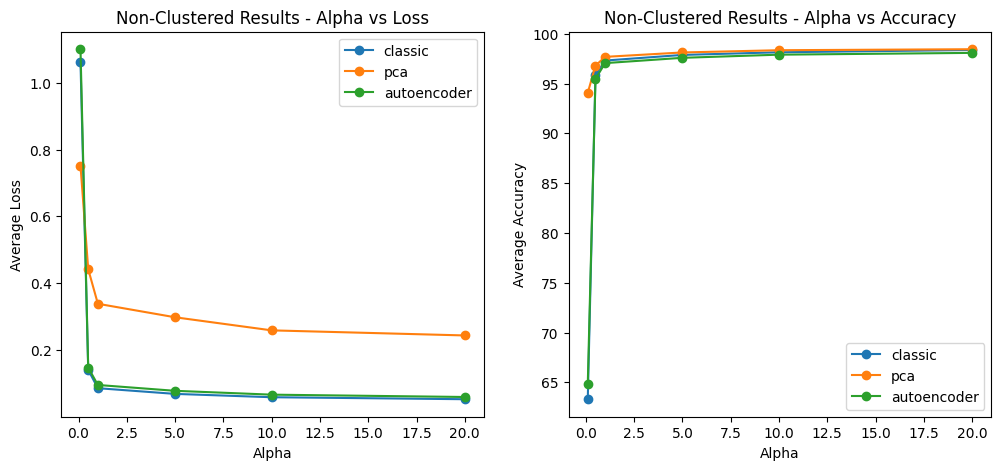


Clustered Results:
classic:
  Average Loss: {0.1: 0.29044288291931153, 0.5: 0.10462678813934326, 1: 0.07538869953155516, 5: 0.06381355056762696, 10: 0.05586019315719604, 20: 0.05132245903015137}
  Average Accuracy: {0.1: 90.7275, 0.5: 96.72500000000001, 1: 97.65, 5: 97.975, 10: 98.2525, 20: 98.395}
pca:
  Average Loss: {0.1: 0.55937759475708, 0.5: 0.38537403030395506, 1: 0.3138889770507812, 5: 0.2804942649841309, 10: 0.2572070163726807, 20: 0.23999321327209472}
  Average Accuracy: {0.1: 95.32000000000001, 0.5: 97.3125, 1: 97.99000000000001, 5: 98.27250000000001, 10: 98.39499999999998, 20: 98.46249999999999}
autoencoder:
  Average Loss: {0.1: 0.24808743934631347, 0.5: 0.11496018829345703, 1: 0.08367300605773925, 5: 0.07195330152511596, 10: 0.06319408864974975, 20: 0.057246300601959225}
  Average Accuracy: {0.1: 92.52, 0.5: 96.54499999999999, 1: 97.41499999999999, 5: 97.7825, 10: 97.9925, 20: 98.16250000000001}


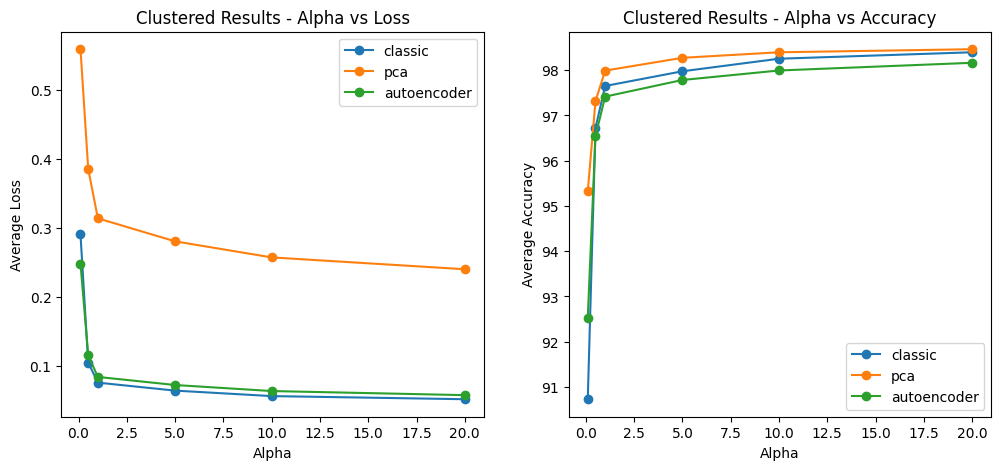

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Alpha vs Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Alpha vs Accuracy')
    plt.legend()
    
    plt.savefig(filename)
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
